In [1]:
%pylab inline
import cv2 as cv
import numpy as np
import argparse

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 

In [3]:
#     # window size is WxW
# C_Thr = 0.43    # threshold for coherency
# LowThr = 35     # threshold1 for orientation, it ranges from 0 to 180
# HighThr = 57    # threshold2 for orientation, it ranges from 0 to 180

# from
def calcGST(inputIMG, w):
    """
    from https://docs.opencv.org/4.2.0/d4/d70/tutorial_anisotropic_image_segmentation_by_a_gst.html
    :param inputIMG:
    :param w:
    :return:
    """
    img = inputIMG.astype(np.float32)
    # GST components calculation (start)
    # J =  (J11 J12; J12 J22) - GST
    img_diff_x = cv.Sobel(img, cv.CV_32F, 1, 0, 3) #Calculates the first image derivatives using an extended Sobel operator
    img_diff_y = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    img_diff_xy = cv.multiply(img_diff_x, img_diff_y)

    img_diff_xx = cv.multiply(img_diff_x, img_diff_x)
    img_diff_yy = cv.multiply(img_diff_y, img_diff_y)
    J11 = cv.boxFilter(img_diff_xx, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(img_diff_yy, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(img_diff_xy, cv.CV_32F, (w, w))
    # GST components calculations (stop)
    # eigenvalue calculation (start)
    # lambda1 = J11 + J22 + sqrt((J11-J22)^2 + 4*J12^2)
    # lambda2 = J11 + J22 - sqrt((J11-J22)^2 + 4*J12^2)
    tmp1 = J11 + J22
    tmp2 = J11 - J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0 * tmp3)
    lambda1 = tmp1 + tmp4  # biggest eigenvalue
    lambda2 = tmp1 - tmp4  # smallest eigenvalue
    # eigenvalue calculation (stop)
    # Coherency calculation (start)
    # Coherency = (lambda1 - lambda2)/(lambda1 + lambda2)) - measure of anisotropism
    # Coherency is anisotropy degree (consistency of local orientation)
    coherency = cv.divide(lambda1 - lambda2, lambda1 + lambda2)
    # Coherency calculation (stop)
    # orientation angle calculation (start)
    # tan(2*Alpha) = 2*J12/(J22 - J11)
    # Alpha = 0.5 atan2(2*J12/(J22 - J11))
    orientation = cv.phase(J22 - J11, 2.0 * J12, angleInDegrees=True)
    orientation = 0.5 * orientation
    # orientation angle calculation (stop)
    return coherency, orientation

In [22]:
imgIn_pre = cv.imread("sharad_data/s_00429402_thm.jpg", cv.IMREAD_GRAYSCALE)
#imgIn_pre = cv.imread("sharad_data/s_00387302_thm.jpg", cv.IMREAD_GRAYSCALE)

imgIn = cv.fastNlMeansDenoising(imgIn_pre,None,22,7,21)
imgInSquare = imgIn[1600:3600,2900:4900]
imgInTiny = imgIn[1700:3400,2600:5000]

W = 10

imgCoherency, ori = calcGST(imgInTiny, W)
imgCoherencySquare, oriSquare = calcGST(imgInSquare, W)

ori[ori>=90] -=180

_, imgCoherencyBin = cv.threshold(imgCoherency,0.1, 255, cv.THRESH_BINARY) #2nd value: C_Thr
_, imgCoherencyBinSquare = cv.threshold(imgCoherencySquare,0.1, 255, cv.THRESH_BINARY) 

ori_bin = cv.inRange(ori, -50, 50)
ori_binSquare = cv.inRange(oriSquare, -50, 50)

imgBin = cv.bitwise_and(imgCoherencyBin, ori_bin.astype(np.float32))
imgBinSquare = cv.bitwise_and(imgCoherencyBinSquare, ori_binSquare.astype(np.float32))

In [23]:
dilation_size = 5
element = cv.getStructuringElement( cv.MORPH_ELLIPSE,
                                       ( 2*dilation_size + 1, 2*dilation_size+1 ),
                                       ( dilation_size, dilation_size ) );

In [24]:
eroded = cv.erode(imgBin, element)
imgBin = cv.dilate(eroded, element)

In [25]:
#res = np.uint8(0.5*(imgIn + imgBin))
resTiny = np.uint8(0.5*(imgInTiny + imgBin))
edges = cv.Canny(imgInTiny,50,100) #2nd,3rd: lower and upper threshold

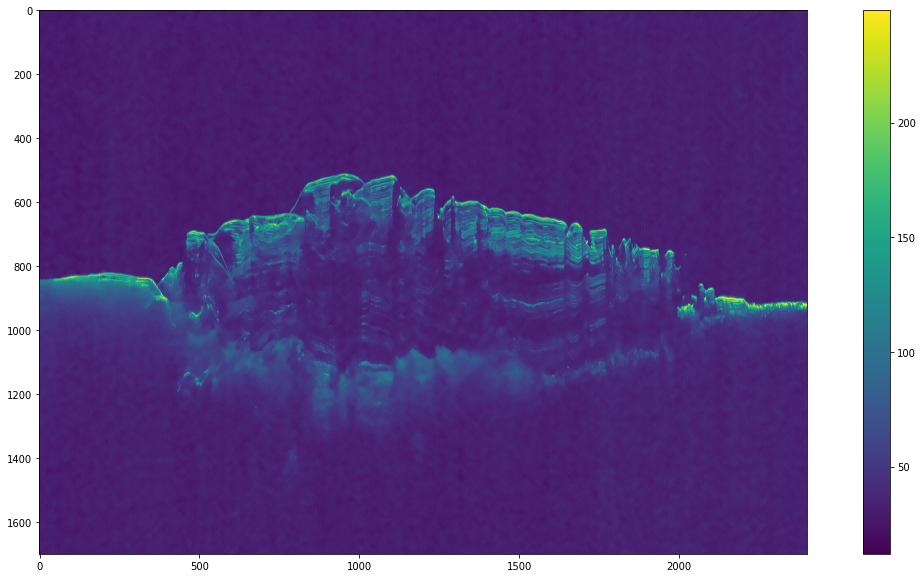

In [27]:
figure(figsize=(20,10))

imshow(imgInTiny)
colorbar()

385


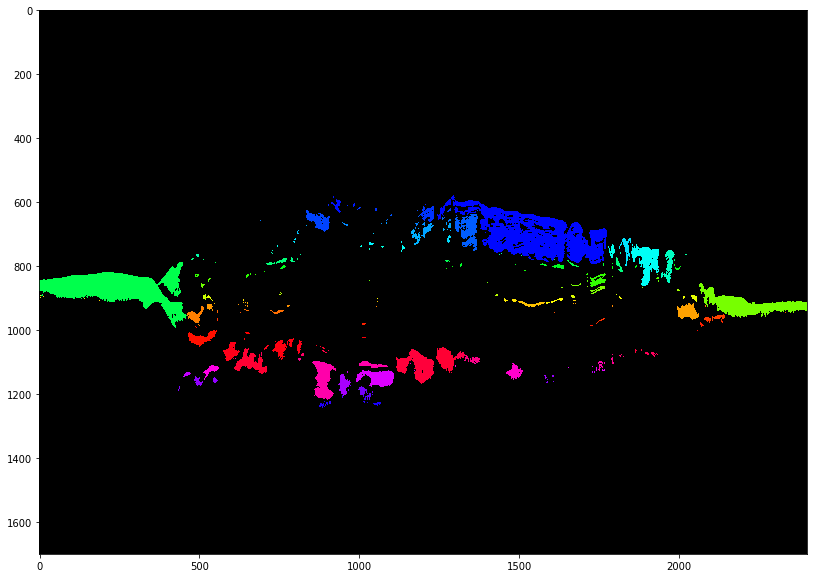

In [51]:
img = cv.threshold(imgInTiny, 70, 255, cv.THRESH_BINARY)[1]  # ensure binary

num_labels, labels_im = cv.connectedComponents(img)
print(num_labels)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels)) #each label gets a different hue
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch]) #each element of the output array will be a concatenation of the elements of the input arrays

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

    #cv.imshow('labeled.png', labeled_img)
    #cv.waitKey()

figure(figsize=(20,10))
a = imshow_components(labels_im)
imshow(a)

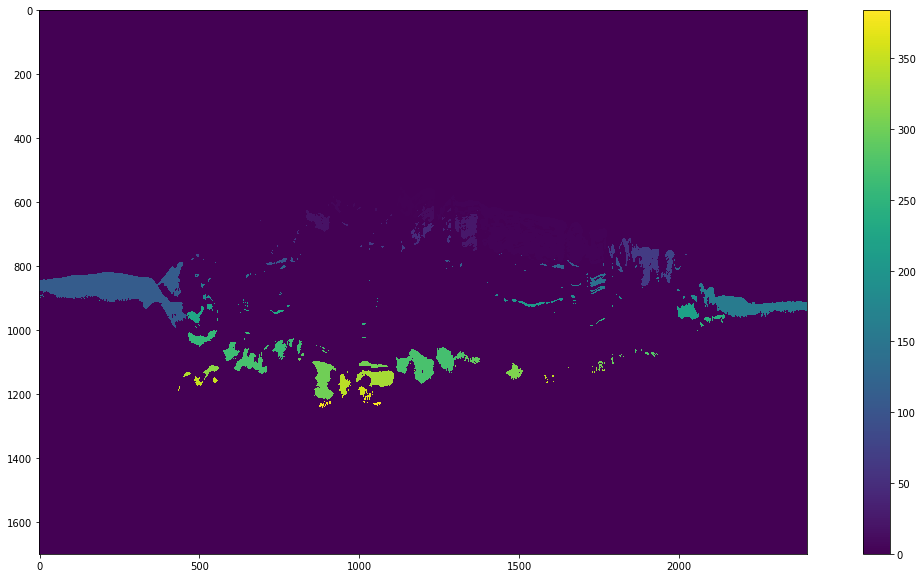

In [52]:
figure(figsize=(20,10))
imshow(labels_im)
colorbar()

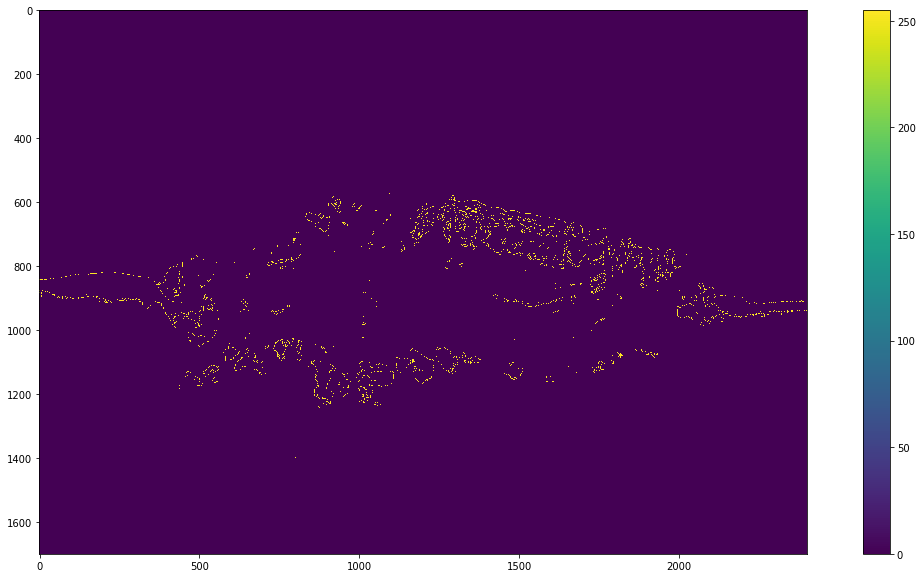

In [53]:
cannylab = cv.Canny(a,50,100)
figure(figsize=(20,10))
imshow(cannylab)
colorbar()

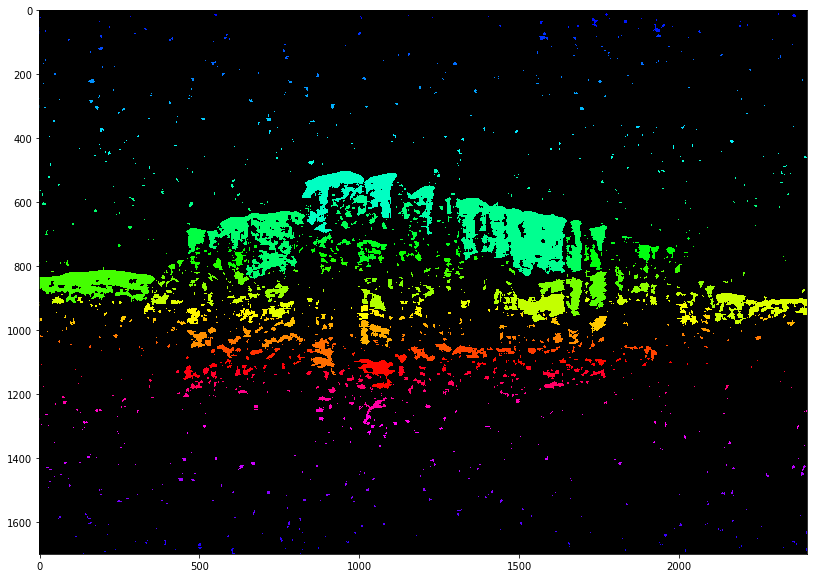

In [54]:
def connected_components_for_binaryimg(img):
    num_labels, labels = cv.connectedComponents(img)
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    #print (blank_ch)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    figure(figsize=(20,10))
    imshow(labeled_img)


ori_conncomp = connected_components_for_binaryimg(ori_bin)    

# Selection of bigger components

In [55]:
def equallabels(labels_im, number):
    numlist=[]
    for i in range(labels_im.shape[0]):
        for j in range(labels_im.shape[1]):
            if labels_im[i][j] == number:
                numlist.append(labels_im[i][j])
            else:
                pass
    return len(numlist)
            
equallabels(labels_im,1)

#equal to find 5° column of cv.connectedComponentsWithStats for a specific row (number)

47804

In [33]:
def concompmean(image,thr):
    lens=[]
    img = cv.threshold(image, thr, 255, cv.THRESH_BINARY)[1]
    num_labels, labels_im = cv.connectedComponents(img)
    for k in range(num_labels):
        newlen = equallabels(labels_im, k)
        lens.append(newlen)
    print (lens)
    return (np.mean(lens))

#returns np.mean(stats[:,4])

In [59]:
#select connected components with pixel area > certain value (valuemean)

def selection(img):
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(img)
    #print (stats.shape)

    #n° stats rows: n° of connected components
    #5° column stats: number of pixel of that connected component
    #other stats columns describe the box thar contains each component

    areas = stats[:,4]
    areas1 = areas.tolist()
    valuemean = np.mean(areas1)
    print ('Total number of connected components:', len(areas1))
    print ('Average area of connected components:', valuemean)

    bigareasindex = []
    bigareas = []

    for i in areas1:
        if i>=valuemean:
            bigareasindex.append(areas1.index(i))
            bigareas.append(i)

    print ('Labels of connected components with pixel area higher than average:', bigareasindex)  #index 0 : background
    print ('Number of pixels of each selected area:', bigareas) 
    print('')

    bigareasarray = np.array([bigareasindex, bigareas]).T
    print (bigareasarray)
    return bigareasindex, bigareas, bigareasarray

index, areas, arearray = selection(img)

Total number of connected components: 385
Average area of connected components: 10597.402597402597
Labels of connected components with pixel area higher than average: [0, 1, 4, 111, 160]
Number of pixels of each selected area: [3863043, 47804, 44497, 34994, 13090]

[[      0 3863043]
 [      1   47804]
 [      4   44497]
 [    111   34994]
 [    160   13090]]


New label for 0 component: 0
New label for 1 component: 51
New label for 4 component: 102
New label for 111 component: 153
New label for 160 component: 204


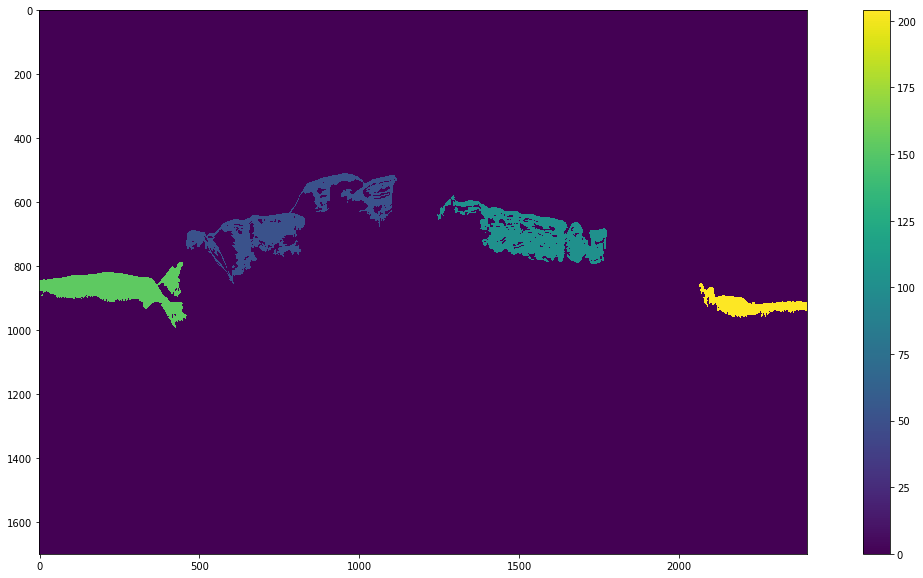

In [60]:
#new array image with only the components having area[pixel]> average area of all components

def newimgbigcomponents(img,bigareasindex):
    new= np.zeros_like(img,dtype='int32')
    num_labels, labels_im = cv.connectedComponents(img)
    hue = range(0, 255, int(255/len(bigareasindex)))     #set new colors for the selected components in range(0,255)
    for i in range(len(bigareasindex)):       
        #new += np.where(labels_im == bigareasindex[i], labels_im, 0)  #gives problems showing components with label>255
        new += np.where(labels_im == bigareasindex[i], hue[i], 0)    #selected components are mantained with a new label in range(0,255)
        print ('New label for', bigareasindex[i], 'component:', hue[i])
    return new

figure(figsize=(20,10))
imshow(newimgbigcomponents(img,index))
colorbar()

New label for 0 component: 0
New label for 1 component: 51
New label for 4 component: 102
New label for 111 component: 153
New label for 160 component: 204


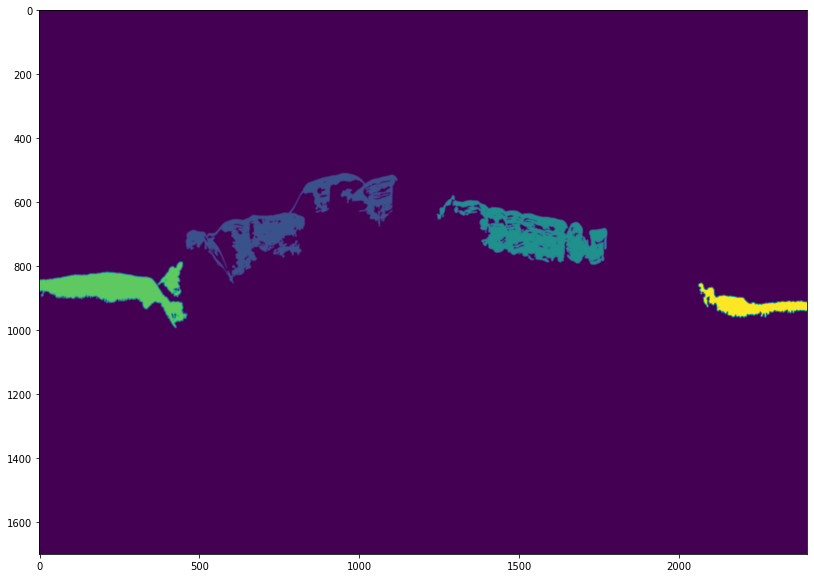

In [61]:
#with edges
figure(figsize=(20,10))
imshow(newimgbigcomponents(img,index),interpolation='bicubic')

[[1 0 0 0 0]
 [0 0 0 0 1]]
[[1 0 3 0 0]
 [3 3 0 0 1]]
[[1 0 3 0 5]
 [3 3 0 0 1]]


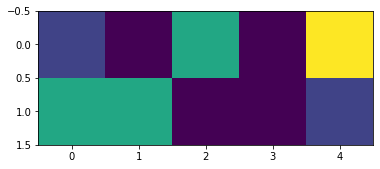

In [18]:
#test
a = np.array([[1,2,3,4,5],[3,3,6,4,1]])
b = np.array([1,3,5])
c = np.array([[0,0,0,0,0],[0,0,0,0,0]])


for i in range(len(b)):
    c += np.where(a == b[i], a, 0)
    print (c)
    imshow(c)

In [49]:
indexoribin, areasoribin, arrayoribin = selection(ori_bin)

Total number of connected components: 2567
Average area of connected components: 1589.4039735099338
Labels of connected components with pixel area higher than average: [0, 541, 544, 583, 621, 685, 715, 728, 748, 807, 982, 1016, 1062, 1082, 1120, 1173, 1198, 1207, 1244, 1259, 1280, 1381, 1442, 1481, 1500, 1546, 1606, 1710]
Number of pixels of each selected area: [3772196, 13717, 7963, 4682, 47220, 25671, 5029, 2424, 2972, 2607, 21521, 4726, 3606, 2374, 1965, 2432, 9354, 5103, 5963, 2044, 1660, 1600, 1899, 1769, 1791, 4041, 2327, 4707]

[[      0 3772196]
 [    541   13717]
 [    544    7963]
 [    583    4682]
 [    621   47220]
 [    685   25671]
 [    715    5029]
 [    728    2424]
 [    748    2972]
 [    807    2607]
 [    982   21521]
 [   1016    4726]
 [   1062    3606]
 [   1082    2374]
 [   1120    1965]
 [   1173    2432]
 [   1198    9354]
 [   1207    5103]
 [   1244    5963]
 [   1259    2044]
 [   1280    1660]
 [   1381    1600]
 [   1442    1899]
 [   1481    1769]
 [ 

New label for 0 component: 0
New label for 541 component: 9
New label for 544 component: 18
New label for 583 component: 27
New label for 621 component: 36
New label for 685 component: 45
New label for 715 component: 54
New label for 728 component: 63
New label for 748 component: 72
New label for 807 component: 81
New label for 982 component: 90
New label for 1016 component: 99
New label for 1062 component: 108
New label for 1082 component: 117
New label for 1120 component: 126
New label for 1173 component: 135
New label for 1198 component: 144
New label for 1207 component: 153
New label for 1244 component: 162
New label for 1259 component: 171
New label for 1280 component: 180
New label for 1381 component: 189
New label for 1442 component: 198
New label for 1481 component: 207
New label for 1500 component: 216
New label for 1546 component: 225
New label for 1606 component: 234
New label for 1710 component: 243


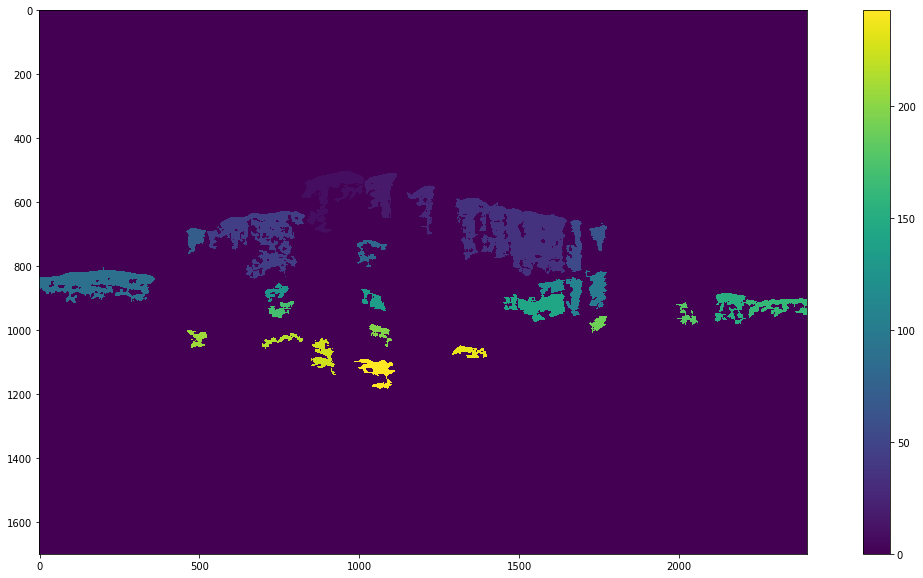

In [50]:
figure(figsize=(20,10))
imshow(newimgbigcomponents(ori_bin,indexoribin))
colorbar()

# Interactive

In [37]:
def threshold(img, thr):
    img = cv.threshold(img, thr, 255, cv.THRESH_BINARY)[1]
    figure(figsize=(20,10))
    imshow(img)

interact(threshold, img=fixed(imgInTiny), thr=(0,255))

interactive(children=(IntSlider(value=127, description='thr', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.threshold(img, thr)>

In [38]:
def connected_components(img, thr):
    img = cv.threshold(img, thr, 255, cv.THRESH_BINARY)[1]  # ensure binary
    num_labels, labels = cv.connectedComponents(img)
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    #print (blank_ch)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    figure(figsize=(20,10))
    imshow(labeled_img)

interact(connected_components, img=fixed(imgInTiny), thr=(0,255))

interactive(children=(IntSlider(value=127, description='thr', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.connected_components(img, thr)>